In [132]:
# definir los imports en esta celda
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
import string


#### 1. Introducción:  los problemas de la detección del sarcasmo

El sarcasmo es una forma de ironía que ocurre cuando hay una discrepancia entre el significado literal de un
enunciado y su significado pretendido. Esta discrepancia se utiliza para expresar una forma de actitud disociativa
hacia una proposición anterior, a menudo en la forma de desprecio o derogación (Wilson, 2006).

La tarea de la detección automática del sarcasmo debe lidiar con el problema del significado pretendido por el emisor y el significado percibido por el receptor. El problema de cómo identificar el sarcasmo para un humano está anclado en aspectos del lenguaje que traspasan el mero signo escrito (es decir, el conjunto de palabras escritas que conforman el texto), y suponen una serie de elementos culturales, sociales e históricos para su correcta comprensión (y aun así, teniendo todo lo que uno podría "necesitar" para enteder el sarcasmo, sucede muchas veces que no lo captamos).

El sarcasmo está presente en gran parte de las interacciones que suceden en las redes sociales. Y si es imperativo tener un modelo computacional que lo pueda detectar, la calidad de dicho modelo dependerá necesariamente de la calidad de la información con la que lo "alimentemos". 

La idea es avanzar sobre el corpus presente conociendo estas limitaciones, y explorar las posibilidades que nos brinda nuestro conjunto de datos para estudiar el problema y hasta incluso aventurar con alguna recomendación metodológica que mejore eventualmente el estado del arte.

#### 2. Procesamiento de datos, análisis exploratorio y normalización del corpus

El coropora se compone de 3 corpus de comentarios realizados encontrados en la web. Estos corpus son obtenidos a partir del Internet Argument Corpus (IAC) 2.0 (Abbott et al., 2016). Esta es una colección de corpus para la investigación en el debate político en foros de Internet. Consta de tres conjuntos de datos: 4 foros (414.000 publicaciones), ConvinceMe (65.000 publicaciones) y una muestra de CreateDebate (3.000 publicaciones). Incluye anotaciones de temas, caracterizaciones de respuestas (4 foros) y diversas posturas. 

Hay que notar algo importante: los documentos en cada uno de estos coprus poseen caracterítcias estructurales distitnas, tal como señalan Oraby et al. (2016). Esto significa que dos corpus, HYP y RQ buscan capturar un tipo específico de sarcasmo cada uno: hipérboles y pregutnas retóricas, respectivamente. GEN, por otro lado, captura tanto hipérboles como preguntas críticas, a la vez que otro tipo de sarcasmos (podríamos llamarlos "genéricos") lo que lo hace un conjunto heterogéneo en su composición.

¿Es esta información relevante? Nuestra intuición es que sí. La idea de recopilar corpus adicionales para preguntas retóricas e hipérboles es, según los autores del corpus, aumentar la diversidad del corpus, y que nos permita explorar
las diferencias semánticas entre expresiones sarcásticas y expresiones no sarcásticas cuando las señales léxico-sintácticas particulares se mantienen constantes. Dicho de otro modo, es poder identificar qué sucede con los modelos cuando la información que se tiene a disposición para separar una categoría de otra muestra elementos constantes tanto en una categoría como en otra. ¿Son capaces de encontrar entonces estructuras semánticas más "profundas", asociadas obviamente a signos (como palabras o frases) que aparecan en los documentos?

A continuación caragamos los datasets para ver en detalle sus características.




In [12]:
#GEN o generico
df_gen = pd.read_csv("../datasets/GEN-sarc-notsarc.csv")
#HYP o hipérboles
df_hyp = pd.read_csv('../datasets/HYP-sarc-notsarc.csv')
#RQ o preguntas retóricas
df_rq = pd.read_csv('../datasets/RQ-sarc-notsarc.csv')

df1 = pd.concat([df_gen, df_hyp, df_rq], ignore_index=True)
df1.head()
print('El corpora entero se compone de {} documentos, {} en GEN, {} en HYP y {} en RQ'.
      format(len(df1.index), len(df_gen), len(df_hyp), len(df_rq)))
                

El corpora entero se compone de 9386 documentos, 6520 en GEN, 1164 en HYP y 1702 en RQ


In [17]:
df_gen.head()

,class,id,text
0,notsarc,1,"If that's true, then Freedom of Speech is doom..."
1,notsarc,2,Neener neener - is it time to go in from the p...
2,notsarc,3,"Just like the plastic gun fear, the armour pie..."
3,notsarc,4,So geology is a religion because we weren't he...
4,notsarc,5,Well done Monty. Mark that up as your first ev...


En este punto debemos entrar en las especificaciones de cada dataset.
Debemos notar lo siguiente:

* El dataset **RQ**: se compone en parte de 357 documentos que aparecen en el corpus **GEN**;
* El dataset **HYP**: se compone en parte de 30 que aparecen en el corpus **GEN**;

Por ende, la manera correcta de proceder es analizar el comportamiento de los modelos con cada uno de estos sets primero. Luego de obtener resultados, en una tercera instancia podríamos concatenar los tres corpus en uno solo, cuidando de remover aquellos documentos repetidos.

In [13]:
# Algunas funciones de interés 

# Remover puntuación de nuestro dataset
def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

# Remover las stopwords de nuestro dataset
def remove_stopwords(text):
    stop = set(stopwords.words("english"))
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

#### 2. Normalización de texto y preprocesamiento

En esta sección comenzamos a preparar los documentos para cada set. Como la tarea de reconocimiento de sarcasmo es una tarea de clasificación, y en este caso tenemos las etiquetas, entonces podemos empezar a separar nuestras etiquetas de los 
documentos y a procesarlas a cada una por separado.

In [21]:
#Antes que nada, reemplazo las etiquetas por valores numéricos, procesables por el modelo
df_gen.loc[df_gen['class']=='notsarc','class'] = 0
df_gen.loc[df_gen['class']=='sarc','class'] = 1

df_hyp.loc[df_hyp['class']=='notsarc','class'] = 0
df_hyp.loc[df_hyp['class']=='sarc','class'] = 1

df_rq.loc[df_rq['class']=='notsarc','class'] = 0
df_rq.loc[df_rq['class']=='sarc','class'] = 1


In [58]:
#Y separamos las etiquetas de los documentos, de manera tal que nos queden dos features distintas.
#Como en esta matriz solo tenemos tres columnas, podemos excluir esta feature del conjunto de entrenamiento.

X_gen = df_gen['text']
y_gen = df_gen['class']
y_gen = y_gen.astype('int')

X_hyp = df_hyp['text']
y_hyp = df_hyp['class']
y_hyp = y_hyp.astype('int')

X_rq = df_rq['text']
y_rq = df_rq['class']
y_rq = y_rq.astype('int')



#### 2.1 Bag of Words
En este punto querría disponer de mi información tokenizada y filtrada. Decidimos no eliminar stopwords no lemmatizar de entrada porque no sabemos si al hacer esto estaríamos eliminando información crucial para la tarea. Así que este tratamiento se deja para una segunda etapa de ingeniería de features. Dado que queremos trabajar con le corpus tokenizado aprovechamos y creamos una **bag of words** que a su vez nos pemritirá trabajar con ngramas, aumentado así la información para el análisis.

In [65]:
#Definimos uan función que devuelve un modelo
def count_vect(train_data, ngrams=(1, 1)):
    count_vectorizer = CountVectorizer(ngram_range=ngrams)
    emb_train = count_vectorizer.fit_transform(train_data)    
    return emb_train, count_vectorizer

In [63]:
#creamos los bag of words
cv_gen,  cv1 = count_vect(X_gen, ngrams=(1, 3))
cv_hyp, cv2 = count_vect(X_hyp, ngrams=(1, 3))
cv_rq, cv3 = count_vect(X_rq, ngrams=(1, 3))

In [68]:
#Preparamos los conjuntos de entrenamiento para usarlos con los modelos
#GEN
X_traincvgen, X_testcvgen, y_traincvgen, y_testcvgen = train_test_split(cv_gen, y_gen, test_size=0.2, random_state=42)
#HYP
X_traincvhyp, X_testcvhyp, y_traincvhyp, y_testcvhyp = train_test_split(cv_hyp, y_hyp, test_size=0.2, random_state=42)
#RQ
X_traincvrq, X_testcvrq, y_traincvrq, y_testcvrq = train_test_split(cv_rq, y_rq, test_size=0.2, random_state=42)

#### 2.2 Term Frequency Inverse Document Frequency

Con la misma lógica que en el punto anterior, creo ahora un modelo de TFIDF. Es de esperar que este tratamiento mejore el rendimiento de los modelos dado que su tratamiento de la información supone ciertas ventajas sobre el simple conteo de frecuencia de un ngrama dado por el bag of words. 

In [66]:
#Definimos uan función que devuelve un modelo
def tfidf(train_data, ngrams=(1, 1)):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrams)
    train = tfidf_vectorizer.fit_transform(train_data)
    return train, tfidf_vectorizer

In [67]:
#creamos los modelos tfidf
tf_gen, cv1 = tfidf(X_gen, ngrams=(1, 3))
tf_hyp, cv2 = tfidf(X_hyp, ngrams=(1, 3))
tf_rq, cv3 = tfidf(X_rq, ngrams=(1, 3))

In [69]:
#Preparamos los conjuntos de entrenamiento para usarlos con los modelos
#GEN
X_traintfgen, X_testtfgen, y_traintfgen, y_testtfgen = train_test_split(tf_gen, y_gen, test_size=0.2, random_state=42)
#HYP
X_traintfhyp, X_testtfhyp, y_traintfhyp, y_testtfhyp = train_test_split(tf_hyp, y_hyp, test_size=0.2, random_state=42)
#RQ
X_traintfrq, X_testtfrq, y_traintfrq, y_testtfrq = train_test_split(tf_rq, y_rq, test_size=0.2, random_state=42)

#### 3. Modelización 
#### 3.1 Regresión Logística
Teniedo los conjuntos listos, podemos empezara a probar distintos modelos. Probamos primero con una **regresión logística**

#### 3.1.1 Rregesión logística aplicada a Bag fo words

In [77]:
#GEN
lr_gen = LogisticRegression(class_weight="balanced")
lr_gen.fit(X_traincvgen, y_traincvgen)
lr_predgen = lr_gen.predict(X_testcvgen)
#HYP
lr_hyp = LogisticRegression(class_weight="balanced")
lr_hyp.fit(X_traincvhyp, y_traincvhyp)
lr_predhyp = lr_hyp.predict(X_testcvhyp)
#RQ
lr_rq = LogisticRegression(class_weight="balanced")
lr_rq.fit(X_traincvrq, y_traincvrq)
lr_predrq = lr_rq.predict(X_testcvrq)

C:\Users\Eleuterio\Anaconda3\envs\diplo_tutoria\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Preparamos un dataset con los **scores**. Utilizaremos **f1, accuracy, precission y recall**.

In [85]:
#GEN SCORES
f1cvgen = f1_score(y_testcvgen, lr_predgen)
accuracycvgen = accuracy_score(y_testcvgen, lr_predgen)
precisioncvgen = precision_score(y_testcvgen, lr_predgen)
recallcvgen = recall_score(y_testcvgen, lr_predgen)
#HYP SCORES
f1cvhyp = f1_score(y_testcvhyp, lr_predhyp)
accuracycvhyp = accuracy_score(y_testcvhyp, lr_predhyp)
precisioncvhyp = precision_score(y_testcvhyp, lr_predhyp)
recallcvhyp = recall_score(y_testcvhyp, lr_predhyp)
#RQ SCORES
f1cvrq = f1_score(y_testcvrq, lr_predrq)
accuracycvrq = accuracy_score(y_testcvrq, lr_predrq)
precisioncvrq = precision_score(y_testcvrq, lr_predrq)
recallcvrq = recall_score(y_testcvrq, lr_predrq)

cv_scores_columns = {'F1 Score':[f1cvgen, f1cvhyp, f1cvrq],
            'Accuracy Score':[accuracycvgen, accuracycvhyp, accuracycvrq],
            'Precission':[precisioncvgen, precisioncvhyp, precisioncvrq],
            'Recall':[recallcvgen, recallcvhyp, recallcvrq]}

cv_scores = pd.DataFrame(cv_scores_columns, columns = ['F1 Score','Accuracy Score', 'Precission', 'Recall'],
                         index=['GEN','HYP','RQ'])
cv_scores

,F1 Score,Accuracy Score,Precission,Recall
GEN,0.744665,0.733896,0.707692,0.785714
HYP,0.649351,0.652361,0.619835,0.681818
RQ,0.714286,0.706745,0.672043,0.762195


En este punto podemos acceder a la **tabla de contingencia** para cada modelo sobre cada conjunto de la siguiente forma

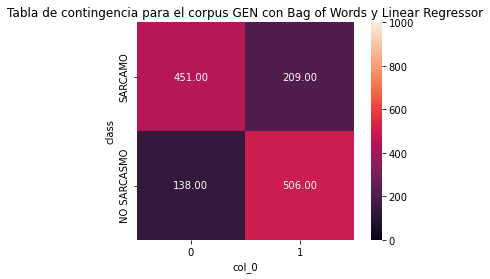

In [136]:
pd_contingency = pd.crosstab(y_testcvgen, lr_predgen)

fig = plt.figure()

plt.clf()

ax = fig.add_subplot(111)

ax.set_aspect(1)

res = sns.heatmap(pd_contingency, annot=True, vmin=0.0, vmax=1000.0, fmt='.2f')

plt.yticks([0.5,1.5], ['SARCAMO', 'NO SARCASMO'],va='center')

plt.title('''Tabla de contingencia para el corpus GEN con Bag of Words y Linear Regressor''')

plt.savefig('confusion_table.png', format='png', bbox_inches='tight')

#### 3.1.2 Regresión logística con TFIDF
                                                                                                                    

In [94]:
#GEN
lr_gen1 = LogisticRegression(class_weight="balanced")
lr_gen1.fit(X_traintfgen, y_traintfgen)
lr_predgen1 = lr_gen1.predict(X_testtfgen)
#HYP
lr_hyp1 = LogisticRegression(class_weight="balanced")
lr_hyp1.fit(X_traintfhyp, y_traintfhyp)
lr_predhyp1 = lr_hyp1.predict(X_testtfhyp)
#RQ
lr_rq1 = LogisticRegression(class_weight="balanced")
lr_rq1.fit(X_traintfrq, y_traintfrq)
lr_predrq1 = lr_rq1.predict(X_testtfrq)

In [95]:
#GEN SCORES
f1tfgen = f1_score(y_testtfgen, lr_predgen1)
accuracytfgen = accuracy_score(y_testtfgen, lr_predgen1)
precisiontfgen = precision_score(y_testtfgen, lr_predgen1)
recalltfgen = recall_score(y_testtfgen, lr_predgen1)
#HYP SCORES
f1tfhyp = f1_score(y_testtfhyp, lr_predhyp1)
accuracytfhyp = accuracy_score(y_testtfhyp, lr_predhyp1)
precisiontfhyp = precision_score(y_testtfhyp, lr_predhyp1)
recalltfhyp = recall_score(y_testtfhyp, lr_predhyp1)
#RQ SCORES
f1tfrq = f1_score(y_testtfrq, lr_predrq1)
accuracytfrq = accuracy_score(y_testtfrq, lr_predrq1)
precisiontfrq = precision_score(y_testtfrq, lr_predrq1)
recalltfrq = recall_score(y_testtfrq, lr_predrq1)

tf_scores_columns = {'F1 Score':[f1tfgen, f1tfhyp, f1tfrq],
            'Accuracy Score':[accuracytfgen, accuracytfhyp, accuracytfrq],
            'Precission':[precisiontfgen, precisiontfhyp, precisiontfrq],
            'Recall':[recalltfgen, recalltfhyp, recalltfrq]}

tf_scores = pd.DataFrame(tf_scores_columns, columns = ['F1 Score','Accuracy Score', 'Precission', 'Recall'],
                         index=['GEN','HYP','RQ'])
tf_scores

,F1 Score,Accuracy Score,Precission,Recall
GEN,0.739130,0.733129,0.714493,0.765528
HYP,0.628319,0.639485,0.612069,0.645455
RQ,0.722892,0.730205,0.714286,0.731707


Podemos sintetizar en la siguiente tabla la información encontrada (**armar la tabla combinando los dos dataframes con los scores**). Como **conclusión provisoria**, podemos ver que sin mucha ingenieria de features (y sin adentrarnos nada en la afinación de parámetros de los modelos) ni limpieza de los corpus, los métodos de preprocesamiento (Bag of Words y TFIDF) no parecen cambiar de manera radical el output del modelo. 

#### 3.2 Naive Bayes

Ahora es hora de probar nuestro dataset con un **clasificador Bayesiano**. Para esto utlizaremos el modelo que viene con scikitlear **multinomilaNB** en cada uno de los corpus procesados. 

#### 3.2.1 Naive Bayes aplicado a Bag of Words

In [97]:
#Entrenamos los modelos con cada uno de los corpus.
#GEN
nb_gen = MultinomialNB()
nb_gen.fit(X_traincvgen, y_traincvgen)
nb_predgen = nb_gen.predict(X_testcvgen)
#HYP
nb_hyp = MultinomialNB()
nb_hyp.fit(X_traincvhyp, y_traincvhyp)
nb_predhyp = nb_hyp.predict(X_testcvhyp)
#RQ
nb_rq = MultinomialNB()
nb_rq.fit(X_traincvrq, y_traincvrq)
nb_predrq = nb_rq.predict(X_testcvrq)

In [98]:
#Preparamos los scores de manera tal que los podamos visualizar 
#GEN SCORES
nb_f1cvgen = f1_score(y_testcvgen, nb_predgen)
nb_accuracycvgen = accuracy_score(y_testcvgen, nb_predgen)
nb_precisioncvgen = precision_score(y_testcvgen, nb_predgen)
nb_recallcvgen = recall_score(y_testcvgen, nb_predgen)
#HYP SCORES
nb_f1cvhyp = f1_score(y_testcvhyp, nb_predhyp)
nb_accuracycvhyp = accuracy_score(y_testcvhyp, nb_predhyp)
nb_precisioncvhyp = precision_score(y_testcvhyp, nb_predhyp)
nb_recallcvhyp = recall_score(y_testcvhyp, nb_predhyp)
#RQ SCORES
nb_f1cvrq = f1_score(y_testcvrq, nb_predrq)
nb_accuracycvrq = accuracy_score(y_testcvrq, nb_predrq)
nb_precisioncvrq = precision_score(y_testcvrq, nb_predrq)
nb_recallcvrq = recall_score(y_testcvrq, nb_predrq)

nbcv_scores_columns = {'F1 Score':[nb_f1cvgen, nb_f1cvhyp, nb_f1cvrq],
            'Accuracy Score':[nb_accuracycvgen, nb_accuracycvhyp, nb_accuracycvrq],
            'Precission':[nb_precisioncvgen, nb_precisioncvhyp, nb_precisioncvrq],
            'Recall':[nb_recallcvgen, nb_recallcvhyp, nb_recallcvrq]}

nbcv_scores = pd.DataFrame(nbcv_scores_columns, columns = ['F1 Score','Accuracy Score', 'Precission', 'Recall'],
                         index=['GEN','HYP','RQ'])
nbcv_scores

,F1 Score,Accuracy Score,Precission,Recall
GEN,0.736156,0.751534,0.773973,0.701863
HYP,0.628099,0.613734,0.575758,0.690909
RQ,0.662420,0.689150,0.693333,0.634146


#### 3.2.2 Naive Bayes aplicado a TFIDF

In [99]:
#Entrenamos los modelos con cada uno de los corpus.
#GEN
nb_gen1 = MultinomialNB()
nb_gen1.fit(X_traintfgen, y_traintfgen)
nb_predgen1 = nb_gen1.predict(X_testtfgen)
#HYP
nb_hyp1 = MultinomialNB()
nb_hyp1.fit(X_traintfhyp, y_traintfhyp)
nb_predhyp1 = nb_hyp1.predict(X_testtfhyp)
#RQ
nb_rq1 = MultinomialNB()
nb_rq1.fit(X_traintfrq, y_traintfrq)
nb_predrq1 = nb_rq1.predict(X_testtfrq)

In [100]:
#GEN SCORES
nb_f1tfgen = f1_score(y_testtfgen, nb_predgen1)
nb_accuracytfgen = accuracy_score(y_testtfgen, nb_predgen1)
nb_precisiontfgen = precision_score(y_testtfgen, nb_predgen1)
nb_recalltfgen = recall_score(y_testtfgen, nb_predgen1)
#HYP SCORES
nb_f1tfhyp = f1_score(y_testtfhyp, nb_predhyp1)
nb_accuracytfhyp = accuracy_score(y_testtfhyp, nb_predhyp1)
nb_precisiontfhyp = precision_score(y_testtfhyp, nb_predhyp1)
nb_recalltfhyp = recall_score(y_testtfhyp, nb_predhyp1)
#RQ SCORES
nb_f1tfrq = f1_score(y_testtfrq, nb_predrq1)
nb_accuracytfrq = accuracy_score(y_testtfrq, nb_predrq1)
nb_precisiontfrq = precision_score(y_testtfrq, nb_predrq1)
nb_recalltfrq = recall_score(y_testtfrq, nb_predrq1)

nb_tf_scores_columns = {'F1 Score':[nb_f1tfgen, nb_f1tfhyp, nb_f1tfrq],
            'Accuracy Score':[nb_accuracytfgen, nb_accuracytfhyp, nb_accuracytfrq],
            'Precission':[nb_precisiontfgen, nb_precisiontfhyp, nb_precisiontfrq],
            'Recall':[nb_recalltfgen, nb_recalltfhyp, nb_recalltfrq]}

nb_tf_scores = pd.DataFrame(nb_tf_scores_columns, columns = ['F1 Score','Accuracy Score', 'Precission', 'Recall'],
                         index=['GEN','HYP','RQ'])
nb_tf_scores

,F1 Score,Accuracy Score,Precission,Recall
GEN,0.643068,0.721626,0.876676,0.507764
HYP,0.653696,0.618026,0.571429,0.763636
RQ,0.643599,0.697947,0.744000,0.567073


Los resultados de aplicar a NB los dos corpus procesados de forma diferente son un tanto distinto a la regresión logística (**armar la tabla combinando los dos dataframes con los scores**). Sin embargo, y **conclusión provisoria**, podemos ver que sin mucha ingenieria de features (y sin adentrarnos nada en la afinación de parámetros de los modelos) ni limpieza de los corpus, los métodos de preprocesamiento (Bag of Words y TFIDF) no parecen cambiar de manera radical el output del modelo. 

#### 3.3 Regresión lineal y PCA aplicadas a TFIDF.

En un cambio metodológico, vamos a tratar los corpus con técnicas de reducción de dimensionalidad. Vamos a aplicar un pipeline donde combinaremos un **regresor** con **PCA**. Lo que buscamos aquí es ver si una reducción dramática de dimensionalidad con esta técnica de embedding genera algún camio drástico, tanto para bien como para mal. Cabe remarcar que todo esto todavía sin hacer una limpieza fina de las features. 

#### 3.3.1 PCA y LR aplicados a Bag of Words
Aplicamos PCA al procesamiento de los corpus por parte del modelo. Como no sabemos a priori cuál sería la cantidad de dimensiones óptima para este caso, realizaremos un gridsearch sobre el corpus GEN en torno a un conjunto limitado de features, y luego aplicaremos esos parámetros en el resto del corpora.

In [110]:
#Cargamos el modelo
svd = TruncatedSVD()
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('svd', svd), ('logistic', logistic)])
param_grid = {'svd__n_components': [5, 50, 100, 200, 500]}

#entrenamos con el conjunto de GEN tratado con CountVectorizer
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_traincvgen, y_traincvgen)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Best parameter (CV score=0.716):
{'svd__n_components': 500}


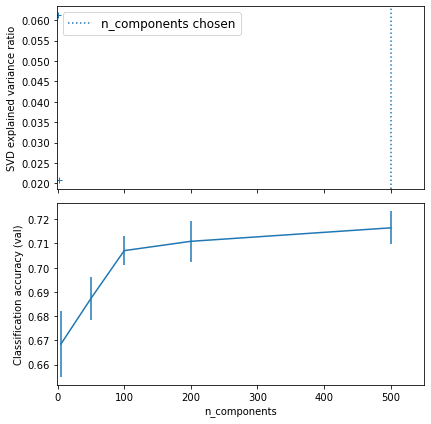

In [119]:
# Ploteamos el spectrum del SVD
svd.fit(X_traincvgen)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, svd.n_components + 1),
         svd.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('SVD explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['svd'].n_components,
            linestyle=':', label='n_components elelgidos')
ax0.legend(prop=dict(size=12))

# Para cada número de componentes, encontramos el mejor resultado del clasificador
results = pd.DataFrame(search.cv_results_)
components_col = 'param_svd__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 550)

plt.tight_layout()
plt.show()

Si bien utilizamos otras métricas que las anteriores en el grid search, podemos ver que a partir de 100 componentes la curva empieza a decrecer. El **fenómeno Hughes** muestra que a medida que aumenta el número de features, el rendimiento del clasificador también aumenta hasta que alcanzamos el número óptimo de features. Podemos asumir solo a  efectos prácticos que este número será alcanzado en algún lugar alrededor de n=1000, pero que el cambio dr'atico opera alrededor de n=100. Así que nos quedamos con ese número de features  para realizar al reducción en el resto de los corpus.

In [127]:
#SVD en GEN
svd_gen = TruncatedSVD(n_components=100)
svd_cvgen = svd_gen.fit_transform(cv_gen)

#SVD en HYP
svd_hyp = TruncatedSVD(n_components=100)
svd_cvhyp = svd_hyp.fit_transform(cv_hyp)

#SVD en RQ
svd_rq = TruncatedSVD(n_components=100)
svd_cvrq = svd_rq.fit_transform(cv_rq)

In [129]:
#Preparamos los conjuntos de entrenamiento para usarlos con los modelos
#GEN
X_trainsvdgen, X_testsvdgen, y_trainsvdgen, y_testsvdgen = train_test_split(svd_cvgen, y_gen, test_size=0.2, random_state=42)
#HYP
X_trainsvdhyp, X_testsvdhyp, y_trainsvdhyp, y_testsvdhyp = train_test_split(svd_cvhyp, y_hyp, test_size=0.2, random_state=42)
#RQ
X_trainsvdrq, X_testsvdrq, y_trainsvdrq, y_testsvdrq = train_test_split(svd_cvrq, y_rq, test_size=0.2, random_state=42)

In [130]:
#Entrenamos los modelos
#GEN
lr_gensvd = LogisticRegression(class_weight="balanced")
lr_gensvd.fit(X_trainsvdgen, y_trainsvdgen)
lr_predgensvd = lr_gensvd.predict(X_testsvdgen)
#HYP
lr_hypsvd = LogisticRegression(class_weight="balanced")
lr_hypsvd.fit(X_trainsvdhyp, y_trainsvdhyp)
lr_predhypsvd = lr_hypsvd.predict(X_testsvdhyp)
#RQ
lr_rqsvd = LogisticRegression(class_weight="balanced")
lr_rqsvd.fit(X_trainsvdrq, y_trainsvdrq)
lr_predrqsvd = lr_rqsvd.predict(X_testsvdrq)

In [131]:
#Analizamos los scores
#GEN SCORES
f1svdgen = f1_score(y_testsvdgen, lr_predgensvd)
accuracysvdgen = accuracy_score(y_testsvdgen, lr_predgensvd)
precisionsvdgen = precision_score(y_testsvdgen, lr_predgensvd)
recallsvdgen = recall_score(y_testsvdgen, lr_predgensvd)
#HYP SCORES
f1svdhyp = f1_score(y_testsvdhyp, lr_predhypsvd)
accuracysvdhyp = accuracy_score(y_testsvdhyp, lr_predhypsvd)
precisionsvdhyp = precision_score(y_testsvdhyp, lr_predhypsvd)
recallsvdhyp = recall_score(y_testsvdhyp, lr_predhypsvd)
#RQ SCORES
f1svdrq = f1_score(y_testsvdrq, lr_predrqsvd)
accuracysvdrq = accuracy_score(y_testsvdrq, lr_predrqsvd)
precisionsvdrq = precision_score(y_testsvdrq, lr_predrqsvd)
recallsvdrq = recall_score(y_testsvdrq, lr_predrqsvd)

svd_scores_columns = {'F1 Score':[f1svdgen, f1svdhyp, f1svdrq],
            'Accuracy Score':[accuracysvdgen, accuracysvdhyp, accuracysvdrq],
            'Precission':[precisionsvdgen, precisionsvdhyp, precisionsvdrq],
            'Recall':[recallsvdgen, recallsvdhyp, recallsvdrq]}

svd_scores = pd.DataFrame(svd_scores_columns, columns = ['F1 Score','Accuracy Score', 'Precission', 'Recall'],
                         index=['GEN','HYP','RQ'])
svd_scores

,F1 Score,Accuracy Score,Precission,Recall
GEN,0.718795,0.699387,0.668000,0.777950
HYP,0.619469,0.630901,0.603448,0.636364
RQ,0.664706,0.665689,0.642045,0.689024


Si comparamos los resultados con la tabla del regresor para bag of words sin PCA, vemos que no parece haber una mejora sustancial, de hecho, en algunos casos parece caer el score. Esto se puede deber a muchas cosas, entre ellas el hecho de que HYP y RQ son más pequeños que GEN, y es difícil lograr bueno modelos a partir de tan poca información. 
Sin embargo, podemos argumentar que no hemos llegado tampoco al número óptimo de reducción de features con **SVD** para bag of Words, en cuyo caso valdría la pena ampliar el estudio con una búsqueda de parámetros exhaustiva.

#### 4. Conclusiones provisorias

De lo visto en los puntos anteriores podemos extraer las siguientes conclusiones provisorias:

1. El tamaño importa: el hecho de que los scores en líneas generales funcionen mejor en GEN que en HYP y RQ puede deberse a la dimensión sensiblemente más pequeña de casos que manejan estos dos últimos. 

2. No parece haber una mejora sustancial a priori que nos permita elegir entre TFIDF y Bag of Words. Es necesario hacer un balance entre varias métricas juntas (prestando especial atención no solo a la accuracy sino a la precission y el recall).

3. Preprosesamiento de la información: claramente estos números son engañosos, con lso datos que contamos ahora podemos volver y realizar mejoras en el preprosesamiento de la información. Algunas preguntas válidas en ese punto son: ¿cómo pesan los signos en el reconocimiento de ditintos tipos de sarcasmo, como por ejemplo, en preguntas retóricas (RQ)? ¿Los emojis y los hashtags, de aparecer, nos ayudan? ¿Vale la pena remover stopwords? ¿Qué podría perderse si eliminamos aquellas palabras que ocurren solo una vez?

4. SVD y el análisis de semánticas latentes no parecieron ayudar demasiado en esta tarea (de hecho, bajaron todos los scores). Sin embargo, parecieran haber una diferencia entre cómo afeta al análisis del corpus GEN en relación a los otros dos. Dos líneas de trabajo se tiene que plantear aquí: un gridsearch para realizar una búsqueda de hiperparámetros sobre cada conjunto (buscando acercanos al número óptimo de features) y luego probar distintos modelos con los cuales analizar la matriz reducida.

5. Es muy probable que con TFIDF es resultado de trabajar con LSA (SVD) de números distintos. Realizar experimentos que apunten a estudiar estos modelos.

#### Bibliografía consultada:

- Shereen Oraby, Vrindavan Harrison, Lena Reed, Ernesto Hernandez, Ellen Riloff and Marilyn Walker (2016). "Creating and Characterizing a Diverse Corpus of Sarcasm in Dialogue." In *The 17th Annual SIGdial Meeting on Discourse and Dialogue (SIGDIAL)*, Los Angeles, California, USA.

- Rob Abbott, Brian Ecker, Pranav Anand, Marilyn A. Walker (2016). "Internet Argument Corpus 2.0: An SQL schema for Dialogic Social Media and the Corpora to go with it." In *Language Resources and Evaluation Conference* (LREC), Portorož, Slovenia.

- Daniel Jurafsky, James H. Martin (2019). *Speech and Language Processing*, Third Edition draft

- Silviu Vlad Oprea, Walid Magdy(2019). "Exploring Author Context for Detecting Intended vs Perceived Sarcasm", In  *Proceedings of the 57th Annual Meeting of the Association for Computational Linguistics*,  pp. 2854–2859 Florence, Italy.

